# Highly Granular Quantization for CICADA
This is my proposal for the Google Summer of Code evaluation task. To prepare for this, I began gathering papers written by authors involved in this project, naturally as well as other key contributors too. In the first place it's my desire to thank everybody who took part in opening the room and advancing knowledge in this topic. Reading them gradually transitioned from a necessity to a pleasure. Consequently, much of the work presented here is inspired by or based upon them:
* "*Gradient-based Automatic Mixed Precision Quantization for Neural Networks On-Chip*" Chang Sun, Thea K. Arrestad, Vladimir Loncar Jennifer Ngadiuba and Maria Spiropulu
* "*Knowledge Distillation for Anomaly Detection*" Adrian Alan Pol, Ekaterina Govorkova, Sonja Gronroos, Nadezda Chernyavskaya,
Philip Harris, Maurizio Pierini, Isobel Ojalvo and Peter Elmer
* "*Autoencoders on FPGAs for real-time, unsupervised new physics detection at 40 MHz
at the Large Hadron Collider*" Ekaterina Govorkova, Ema Puljak, Thea Aarrestad, Thomas James, Vladimir Loncar, Maurizio
Pierini, Adrian Alan Pol, Nicol`o Ghielmetti, Maksymilian Graczyk and Sioni Summers
* "*Automatic heterogeneous quantization of deep neural networks for low-latency inference on the edge for particle detectors*" Claudionor N. Coelho Jr., Aki Kuusela, Shan Li, Hao Zhuang, Thea Aarrestad, Vladimir Loncar, Maurizio Pierini, Adrian Alan Pol, Sioni SummersJennifer and Ngadiuba

Also most of the assumptions that I've been able to make throughout this project wouldn't have been possible without the following presentation:
* "*CICADA: Anomaly Detection for New Physics
Searches at the CMS Level-1 Trigger*" Ho Fung Tsoi

Indeed the shape of each slice, 16x16, is extremely similar to the (18,14) handled by CICADA in their code. It follows that my philosophy, while writing this notebook, has been to simulate the same difficulties too in order to create a (simplified) version that could run in the L1 trigger at LHC:
* extreme low latency
* extremely tight resources from a single FPGA board
* extremely low background rate


**ROAD MAP** - I decided to maintain, within the limits of possibility, coherence between the order of the blocks and the sequence in which they were temporally created. This means that I also kept paths that weren't fully explored or those that didn't succeed. I believe this approach is essential to the comprehension of the overall project, as both the choices and mistakes made along thet development can contribute to is enhancement. <br>
I'll proceed to note (when useful) what happens in each block, with a more precise description inside them:
1. Libraries and Modules
2. Load and Describe Data
3. Data Visualization - exploit plots to get intuitions on how the task is structured, data distribution and what we might tackle
4. Separate Negative and Positive Samples - useful in KD and to test generalization abilities of a model trained only on one type of samples
5. Data Augmentation - initially introduced to prevent overfitting
6. Stored Model - describe what the model at our disposal and evaluate its performance to obtain a baseline
7. Developed Models - present models for a potential QAT + KD approach, as in CICADA
8. KD + QAT - two approaches that resulted in different issues
9. Final Model - turns out we don't need a big architecture at all
10. HGQ
11. Conclusions and Improvements

In [ ]:
#@title 1. Libraries and Modules
import numpy as np
import tensorflow as tf
from pathlib import Path
from numpy.typing import NDArray
import seaborn as sns
import seaborn_image as isns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from generator import RegionETGenerator
import time
import pandas as pd
import matplotlib.pyplot as plt
from qkeras import QActivation, QConv2D, QDense, QDenseBatchnorm, quantized_bits
from tensorflow import keras, data
from keras.models import Model, load_model
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Reshape,
    UpSampling2D,
    Conv2DTranspose
)
import numpy.typing as npt
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model
from drawing import Draw

*requirements.txt* may not work totally fine. In this case you can simply copy it from CICADA repo and add a couple of missing libraries (seaborn_image and HGQ)

### 2. Load and Describe Data

In [3]:
data_path = Path('data')
model_path = Path('model')

In [ ]:
images = np.load(data_path / 'images.npy').astype('float32')
labels = np.load(data_path / 'labels.npy')

In [ ]:
print(f"Data type of images: {images.dtype}")
print(f"Data type of labels: {labels.dtype}")

Data type of images: float32
Data type of labels: int64


In [ ]:
def labels_description(data: NDArray[np.int64]) -> None:
  df = pd.DataFrame(data)
  print(df.describe())
  print(df.info())

def slice_description(data: NDArray[np.float32]) -> None:
  slice = data[0, :, :].reshape(256,)
  df = pd.DataFrame(slice)
  print(df.describe())
  print(df.info())

In [ ]:
slice_description(images)

                0
count  256.000000
mean     0.955877
std      0.908362
min      0.007223
25%      0.306411
50%      0.691741
75%      1.343379
max      6.263326
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       256 non-null    float32
dtypes: float32(1)
memory usage: 1.1 KB
None


Let's take the first image from the tensor to get a peek on the dataset: the 75 quantiles is the most interesting in describing how, due to the distance to the maximum value, most of the pixels are quite dark. <br>
The next goal is to understand the relation between the presence of brighter pixels and a positive labels, given usually most of the pixels belong to the "background"
<br>
I will refer to background as an area where an hypothetical transformer attention wouldn't focus

In [ ]:
# images = images / np.max(images) normalizing didn't have an impact

In [ ]:
labels_description(labels)

                0
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB
None


The dataset is perfectly balanced so a data augmentation for this specific purpose isn't needed

In [ ]:
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=101,)
images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.2, random_state=101,)

### 3. Data Visualization

In [ ]:
def print_random_image(images: NDArray[np.float32], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  plt.imshow(images[index])
  plt.title(f'Label: {labels[index]}')
  plt.show()

def print_image_distribution(images: NDArray[np.float32], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  ax = isns.imghist(images[index])
  plt.title(f'Index: {index}, Label: {labels[index]}')

def print_images_distribution(images: NDArray[np.float32], labels: NDArray[np.int64]) -> None:
  all_pixels = images.flatten()
  plt.figure(figsize=(10, 6))
  sns.histplot(all_pixels, kde=True, color='blue', bins=50)
  plt.title('Histogram of Pixel Intensities for All Images')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')
  plt.show()

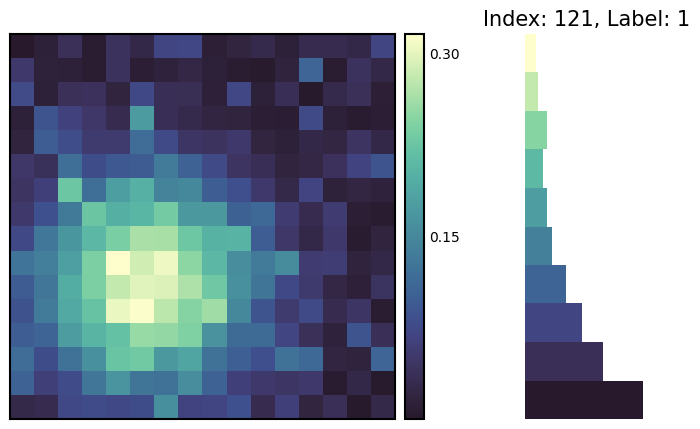

In [ ]:
print_image_distribution(images_train, labels)

This image, who's associated to a label 1, embodies the typical aspect that we willl encounter for positive samples: a round-line structure with brighter pixels in the center and increasingly darker as you move far from it, up to almost noise. This instead if the usual background of negative samples

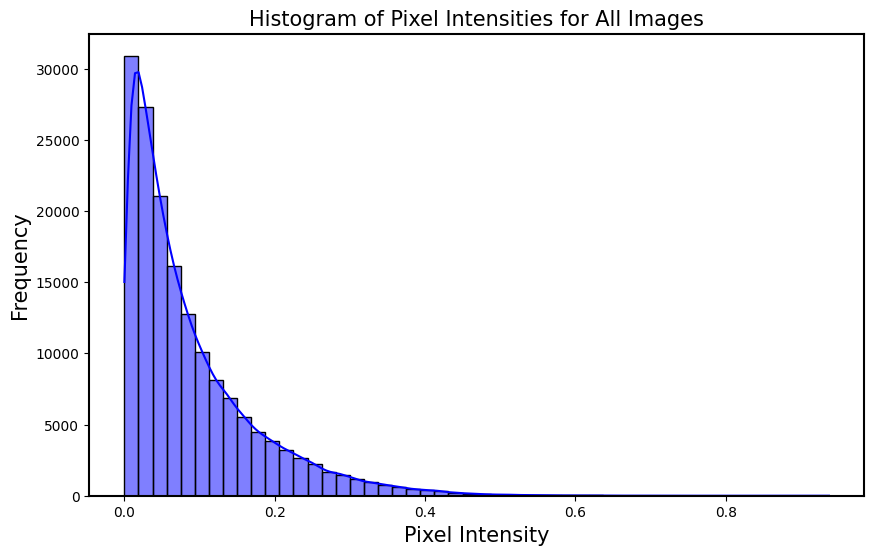

In [ ]:
print_images_distribution(images_train, labels)

Overall, the "average" image is composed mainly of noise in the background with only a couple of brighter pixels

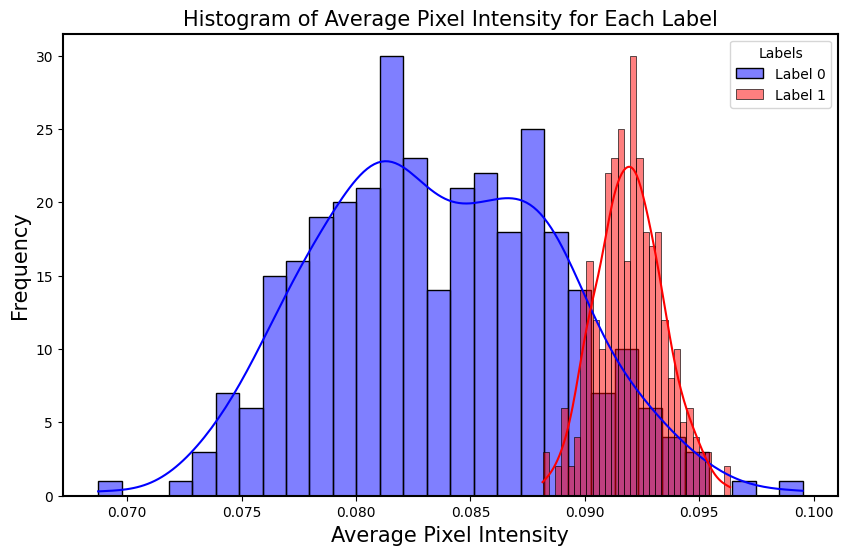

In [ ]:
average_values = np.mean(images_train, axis=(1, 2))
plt.figure(figsize=(10, 6))
sns.histplot(average_values[labels_train == 0], color='blue', label='Label 0', kde=True, bins=30)
sns.histplot(average_values[labels_train == 1], color='red', label='Label 1', kde=True, bins=30)
plt.title('Histogram of Average Pixel Intensity for Each Label')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(title='Labels')

plt.show()


Digging deeper, taking the "average" pixel for both classes we notice two trends:
* negative samples seem to follow a Gaussian distribution, where the variance is determined by thet noise
* positive samples have a much lower variance, as if they do follow a regular pattern where not much is left to chance

<ipython-input-47-673238fbcc19>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')


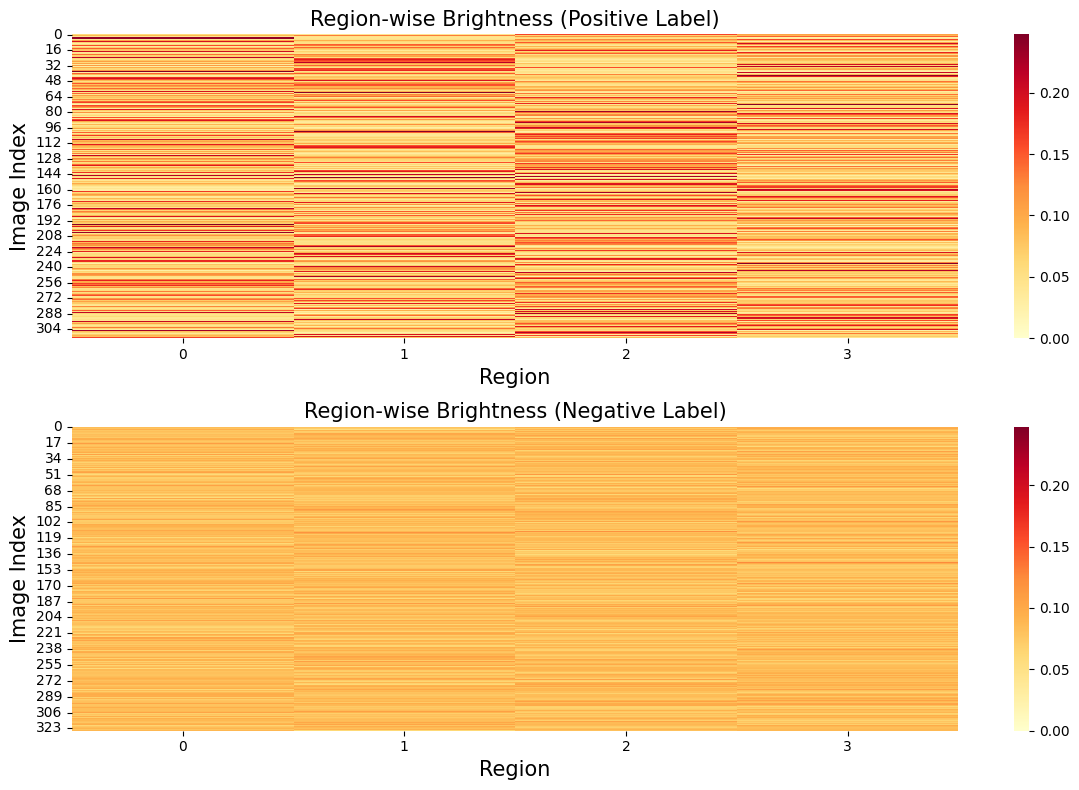

In [ ]:
import matplotlib as mpl

# Function to compute region-wise average intensities (splitting image into 4 quadrants)
def compute_region_average(image):
    # Split the 16x16 image into 4 quadrants
    top_left = image[:8, :8]
    top_right = image[:8, 8:]
    bottom_left = image[8:, :8]
    bottom_right = image[8:, 8:]

    # Compute the average pixel intensity for each region
    return [np.mean(top_left), np.mean(top_right), np.mean(bottom_left), np.mean(bottom_right)]

region_averages = np.array([compute_region_average(img) for img in images_train])
vmax = region_averages.max()
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.heatmap(region_averages[labels_train == 1], cmap='YlOrRd', ax=ax[0], annot=False, vmin = 0, vmax = vmax)
ax[0].set_title('Region-wise Brightness (Positive Label)')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Image Index')

sns.heatmap(region_averages[labels_train == 0], cmap='YlOrRd', ax=ax[1], annot=False, vmin=0, vmax=vmax)
ax[1].set_title('Region-wise Brightness (Negative Label)')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Image Index')

cmap = cm.get_cmap('YlOrRd')
norm = mpl.colors.Normalize(vmin=region_averages.min(), vmax=region_averages.max())

plt.tight_layout()
plt.show()


To demonstrate once again the importance of brightness in giving a correct answer in our task, now we reduce each image to four regions where it's less likely that an arbitrary border can alter results. And, as expected, for positive images we do see a much higher activity

([], [])

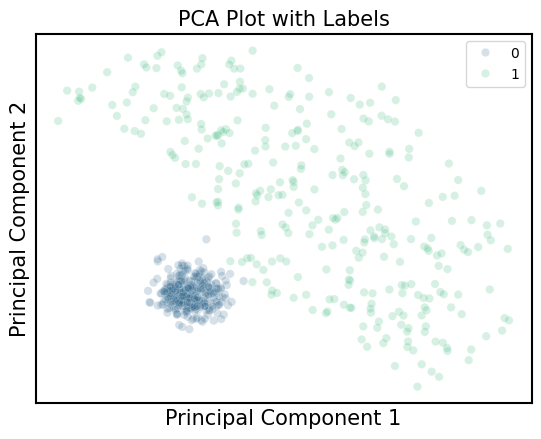

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(images_train.reshape(images_train.shape[0], -1))
sns.scatterplot(x=view[:,0], y=view[:,1], hue=labels_train, alpha=0.2, palette='viridis')
plt.title('PCA Plot with Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks([])
plt.yticks([])

This final plot might be the most revealing one: it clearly shows how well-separated our dataset is, with label0 forming a distinct circle and label1 surrounding it. The sharp separation between the two labels suggests that even large models may not significantly improve performance, as the structure of the data is already well-defined.<br>
If classification isn't that tricky, our next objective is immediately clear: make the algorithm as fast as possible while retaining the same performance

### 4. Separate Positive and Negative Samples
This block's only purpose is to create sub-datasets that can be used:
* by the QAT + KD strategy to train the teacher without outliers, while giving the full spectrum to the student
* for specific analysis on a model's behavior

In [ ]:
X_train = [img for img, label in zip(images_train, labels_train) if label == 0]
y_train = [label for label in labels_train if label == 0]
outlier_train = [img for img, label in zip(images_train, labels_train) if label == 1]
outlier_train_labels = [label for label in labels_train if label == 1]

In [ ]:
type(X_train), type(y_train), type(outlier_train), type(outlier_train_labels)

(list, list, list, list)

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

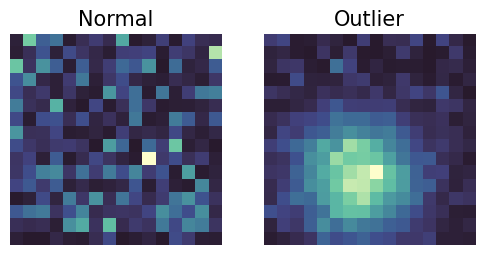

In [ ]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(X_train[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Outlier")
plt.imshow(outlier_train[0])
plt.axis("off")

In [ ]:
len(X_train), len(y_train), len(outlier_train), len(outlier_train_labels), len(images_train)

(326, 326, 314, 314, 640)

In [ ]:
X_val = [img for img, label in zip(images_val, labels_val) if label == 0]
y_val = [label for label in labels_val if label == 0]
outlier_val = [img for img, label in zip(images_val, labels_val) if label == 1]
outlier_val_labels = [label for label in labels_val if label == 1]

In [ ]:
len(X_val), len(y_val), len(outlier_val), len(outlier_val_labels), len(images_val)

(90, 90, 70, 70, 160)

In [ ]:
X_test = [img for img, label in zip(images_test, labels_test) if label == 0]
y_test = [label for label in labels_test if label == 0]
outlier_test = [img for img, label in zip(images_test, labels_test) if label == 1]
outlier_test_labels = [label for label in labels_test if label == 1]

### 5. Data Augmentation
My first intention was to replicate the CICADA architecture with the very same models, however the teacher model was always underfitting. To change this course, I opted for a not too aggressive data augmentation. While this helped, it turns out that the limited quantity of data wasn't the real issue. Instead by developing a second teacher model with 10x less weights, everything worked perfectly fine.<br>
Consequently I abandoned any data augmentation, yet I wouldn't discard it as useless. For instance, we could explor it for quantized models with limited capabilities. However, after we've seen how well the data is divided, I don't expect a huge improvement.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
])

In [ ]:
augmented_images = []
n_copies = 10
for image in X_train:
    for _ in range(n_copies):
        augmented = data_augmentation(tf.expand_dims(image, axis=0))
        augmented_images.append(tf.squeeze(augmented).numpy())
X_train_aug = np.array(augmented_images)
y_train_aug = np.repeat(y_train, n_copies)

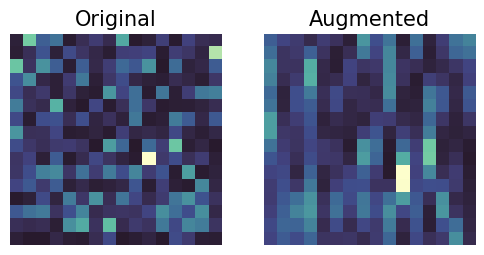

In [ ]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented")
plt.imshow(X_train_aug[1])
plt.axis("off")


plt.show()

### 6. Stored Model
So far we know that we are dealing with a binary classification task and how images appear based on their label. <br>
The already provided model takes an interesting approach: instead of having a final classification layer with a sigmoid activation function, it predicts a value in *R*.<br>
The student model in the CICADA project has the same mechanism. It predicts the expected loss coming from the teacher. This has been trained solely on "negative" samples hence, when it encounters OOD data, we could assume the loss takes a high value. <br>
With this in mind, I decided to normalize the logits. I didn't have time to consider a different technique but this works pretty well as shown by the ROC curve.
<br>
While AUC is extremely reliable to describe our model's performance, I could have used as well other metrics such as F1 score.

In [5]:
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter
        execution_time = end - start
        print(f"Execution time of {func.__name__}: {execution_time:.4f} seconds")
        return result
    return wrapper

In [ ]:
@timer_decorator
def predict(images: NDArray[np.float32]) -> NDArray[np.float32]:
  output = infer(images)
  return output

def normalize_matrix(matrix: NDArray[np.float32]) -> NDArray[np.float32]:
  min_score = np.min(matrix)
  max_score = np.max(matrix)
  normalized_output = []
  for score in matrix:
    normalized_output.append((score - min_score)/(max_score-min_score))
  return np.array(normalized_output)

def get_student_targets(
    model: Model, gen: RegionETGenerator, X: npt.NDArray
) -> data.Dataset:
    X = np.expand_dims(X, axis=-1)
    X_hat = model.predict(X, batch_size=512, verbose=0)
    y = loss(X, X_hat) # FP32 loss
    y = quantize(y)
    #y = quantize(np.log(y) * 32)  # Scaled FP32 loss
    # arguments: input of the teacher model, quantized loss and batch size
    return gen.get_generator(X.reshape((-1, 256, 1)), y, 128, False)

def train_model(
    model: Model,
    training_dataset: data.Dataset,
    validation_dataset: data.Dataset,
    epoch: int = 1,
    steps: int = 1,
    callbacks=None,
    verbose: bool = False,
) -> None:
    model.fit(
        training_dataset,
        steps_per_epoch=len(training_dataset), # the model process the entire dataset
        initial_epoch=epoch,
        epochs=epoch + steps,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=verbose,)

In [7]:
def plot_roc_curve(labs: NDArray[np.int32], preds: NDArray[np.float32]) -> None:
  fpr, tpr, thresholds = roc_curve(labs, preds)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']
input_tensor = tf.convert_to_tensor(images_test, dtype=tf.float32)

In [ ]:
output = predict(input_tensor)
output = output['lambda'].numpy()
normalized_output = normalize_matrix(output)
plot_roc_curve(labels_test, normalized_output)

### 7. Developed Models
This block contains a slightly-modified version of the architectures developed by the CICADA project. As I mentioned, I will soon (in this notebook, in reality it took me quite time) see that this path wasn't the easiest one thus it will be left aside. <br>
I want to highlight in particular *TeacherAutoencoder* that has ~10x less parameters than *TeacherAutoencoderRevised*. This decision was taken to diminish the underfitting. Perhaps, by giving more epoch to train, also *TeacherAutoencoderRevised* would have reached the same level but again time was limited

In [ ]:
class TeacherAutoencoder:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="teacher_inputs_")
        x1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
        p1 = layers.MaxPooling2D((2, 2))(x1)

        x2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
        p2 = layers.MaxPooling2D((2, 2))(x2)

        # Bottleneck
        x = Flatten(name="teacher_flatten")(p2)
        x = Dense(2, activation="relu", name="teacher_latent")(x)
        x = Dense(4 * 4 * 16, name="teacher_dense")(x)
        b = Reshape((4, 4, 16), name="teacher_reshape2")(x)
        # Decoder
        u1 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(b)
        u1 = layers.concatenate([u1, x2])
        u1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)

        u2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u1)
        u2 = layers.concatenate([u2, x1])
        u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
        outputs = Conv2D(
            1,
            (3, 3),
            activation="relu",
            strides=1,
            padding="same",
            name="teacher_outputs",
        )(u2)
        return Model(inputs, outputs, name="teacher")

class TeacherAutoencoderRevised:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape
    def get_model(self):
      inputs = Input(shape=self.input_shape, name="teacher_inputs_")
      x = Reshape((16, 16, 1), name="teacher_reshape")(inputs)
      x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_1")(x)
      x = Activation("relu", name="teacher_relu_1")(x)
      x = AveragePooling2D((2, 2), name="teacher_pool_1")(x)
      x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_2")(x)
      x = Activation("relu", name="teacher_relu_2")(x)
      x = Flatten(name="teacher_flatten")(x)
      x = Dense(80, activation="relu", name="teacher_latent")(x)
      x = Dense(8 * 8 * 30, name="teacher_dense")(x)
      x = Reshape((8, 8, 30), name="teacher_reshape2")(x)
      x = Activation("relu", name="teacher_relu_3")(x)
      x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_3")(x)
      x = Activation("relu", name="teacher_relu_4")(x)
      x = Conv2DTranspose(30, (3, 3), strides=2, padding="same", name="teacher_conv_transpose")(x)
      x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_4")(x)
      x = Activation("relu", name="teacher_relu_5")(x)
      outputs = Conv2D(
          1,
          (3, 3),
          activation="relu",
          strides=1,
          padding="same",
          name="teacher_outputs",
      )(x)
      return Model(inputs, outputs, name="teacher-transpose")


class CicadaV2:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        # quantized_bits takes the following arguments:
        # total number of bits used to represent each weight value
        # number of bits used to represent the integer part
        # 1 bit if signed
        # scaling factor, 1.0 means no scaling
        x = QConv2D(
            4,
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            use_bias=False,
            name="dense2",
        )(x)
        outputs = QActivation("quantized_relu(16, 8)", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")

### 8. KD + QAT Training
I describe here my initial approach, why it has failed and how I would try to fix it. Although in my opinion this is the most interesting one, due to its resemblance to CICADA and the real-world problems that this encounters, it turns out that there's no need at all for it. <br>
I didn't take into consideration other quantization strategies (Post-training or dynamic quantization) because:
* literature agrees that QAT is the best, when labeled data are available
* QKeras handles QAT

In [ ]:
# Turned off checkpoints and loggers while testing

teacher = TeacherAutoencoder((16, 16, 1)).get_model()
teacher.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
#t_mc = ModelCheckpoint(f"models/{teacher.name}", save_best_only=True)
#t_log = CSVLogger(f"models/{teacher.name}/training.log", append=True)

cicada_v2 = CicadaV2((16, 16)).get_model()
cicada_v2.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
#cv2_mc = ModelCheckpoint(f"models/{cicada_v2.name}", save_best_only=True)
#cv2_log = CSVLogger(f"models/{cicada_v2.name}/training.log", append=True)

In [ ]:
teacher.summary()

Model: "teacher"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 teacher_inputs_ (InputLaye  [(None, 16, 16, 1)]          0         []                            
 r)                                                                                               
                                                                                                  
 conv2d_167 (Conv2D)         (None, 16, 16, 8)            80        ['teacher_inputs_[0][0]']     
                                                                                                  
 max_pooling2d_68 (MaxPooli  (None, 8, 8, 8)              0         ['conv2d_167[0][0]']          
 ng2D)                                                                                            
                                                                                            

In [ ]:
gen = RegionETGenerator()

gen_train = gen.get_generator(np.array(X_train_aug), np.array(X_train_aug), 128, )
gen_val = gen.get_generator(images_val, images_val, 512, )

negative_test = gen.get_generator(X_test, X_test, 512, )
positive_test = gen.get_generator(outlier_test, outlier_test, 512, )

negative_test_student = gen.get_generator(np.array(X_test), np.array(y_test), 512, )
positive_test_student = gen.get_generator(np.array(outlier_test), np.array(outlier_test_labels), 512, )
train_student = gen.get_generator(images_train, labels_train, 128, )
X_val_student = outlier_val

In the snippet above, I create all the possible combinations of datasets that I could have used. During the development it was a constant change, hence I do not guarantee to work. However what matters is:
* gen_train - dataset provided to the autoencoder teacher with only normal examples (Adrian Alan Pol, '23), in fact inputs and targets are the same
* positive_test - dataset containing only abnormalities from the test set. Through this I was able to assess the main issue of this approach: teacher was so good at generalizing this task that it could reconstruct positive samples too
* train_student - dataset given to the student model comprehending normal training and OOD images

In [ ]:
for epoch in range(10):
    train_model(
        teacher,
        gen_train,
        gen_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )
    #tmp_teacher = load_model(f"models/{teacher.name}")

    s_gen_train = get_student_targets(teacher, gen, X_train_student)
    s_gen_val = get_student_targets(teacher, gen, X_val_student)

    train_model(
            cicada_v2,
            s_gen_train,
            s_gen_val,
            epoch=10 * epoch,
            steps=10,
            #callbacks=[cv2_mc, cv2_log],
            verbose=1,
        )

This architecture isn't able to distinguish between negative and positive samples. CICADA and "*Knowledge Distillation for Anomaly Detection*" core feature is to exploit teacher's weaknesses, in generalizing to unseen data distribution, to recognize anomalies.
<br>
A dataset easy to classify combined with a good enough teacher, made this instead extremely skilled at reconstructing anomalies. Options that could have been taken into consideration are:
* stronger regularization (e.g. L1/L2 to reach a sparse AE)
* more bottleneck constraints

In [ ]:
teacher.evaluate(negative_test, verbose=1), teacher.evaluate(positive_test)

1/1 [==============================] - 0s 9ms/step - loss: 0.0054


(0.0328376367688179, 0.005389452911913395)

However I noticed that this architecture was missing a key component from the paper: the loss function of the teacher involved only "its errors" while it should have been a joint of its reconstruction loss and student distillation loss. The idea behind it is quite simple:
* the teacher, trained only on normal data, should have a low error on them while high on anomalies
* the student instead, when it sees anomalies, it should predict a high error
* if the two assumptions above are true, then the difference between the actual loss and the predict one is ~0. Otherwise the teacher is trained to give high errors on OOD data, i.e. reduce the area in the latent space with high energy

The following is an attempt to create the custom loss and deploy the co-learning of teacher and student. Issues that I didn't have time to solve came up but, fortunately for me, this approach wasn't necessary. We can get extremely good results without a KD approach.

In [ ]:
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

def autoencoder_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error

def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

# Custom training step
@tf.function
def train_step(inputs, targets, train_student):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass through autoencoder
        reconstructed = teacher(inputs)
        # Compute the autoencoder (reconstruction) loss
        ae_loss = autoencoder_loss(inputs[:, :, :, None], reconstructed)
        adv_loss_sum = tf.constant(0.0, dtype=tf.float32)
        adv_loss = tf.constant(0.0, dtype=tf.float32)
        for batch in train_student:
            input_student, target_student = batch  # Assuming batch is (inputs, targets
            teacher_pred = teacher(input_student)
            loss_teacher = autoencoder_loss(tf.cast(input_student[:, :, :, None], tf.float32), teacher_pred)
            pred_student = cicada_v2(input_student)
            adv_loss = adversarial_loss(loss_teacher, pred_student)
            adv_loss_sum = tf.math.add(adv_loss_sum, tf.reduce_sum(adv_loss))

        total_loss = ae_loss + 0.1 * adv_loss_sum
        print(total_loss)

    # Compute gradients and apply them
    ae_gradients = tape.gradient(total_loss, teacher.trainable_variables)
    discriminator_gradients = tape.gradient(adv_loss, cicada_v2.trainable_variables)

    # Apply gradients
    autoencoder_optimizer.apply_gradients(zip(ae_gradients, teacher.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, cicada_v2.trainable_variables))

    return total_loss

In [ ]:
for epoch in range(2):
    for batch in gen_train:
        inputs, targets = batch
        loss = train_step(inputs, targets, train_student)
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")

In [ ]:
draw = Draw(output_dir='plots', interactive=False)

In [ ]:
def plot_reconstruction(index: int, dataset, model):
    # Extract a single example from the augmented training set
    image_example = dataset[index][np.newaxis, ...]

    # Get the model's prediction
    y_pred = model.predict(image_example)

    # Calculate the error
    error = loss(dataset[index][..., np.newaxis], y_pred)
    print(error)

    # Plot the reconstruction results
    draw.plot_reconstruction_results(
        dataset[index],
        y_pred,
        loss=error[0],
        name="comparison-background",
    )


In [ ]:
plot_reconstruction(25, outlier_test, teacher)

1/1 [==============================] - 0s 11ms/step
[0.00325335]


An example of anomaly reconstruction from the teacher should be in the folder *plots/*



In [ ]:
y_pred_teacher = teacher.predict(np.array(images_test)[:, :, :, None], verbose=1)

7/7 [==============================] - 0s 3ms/step


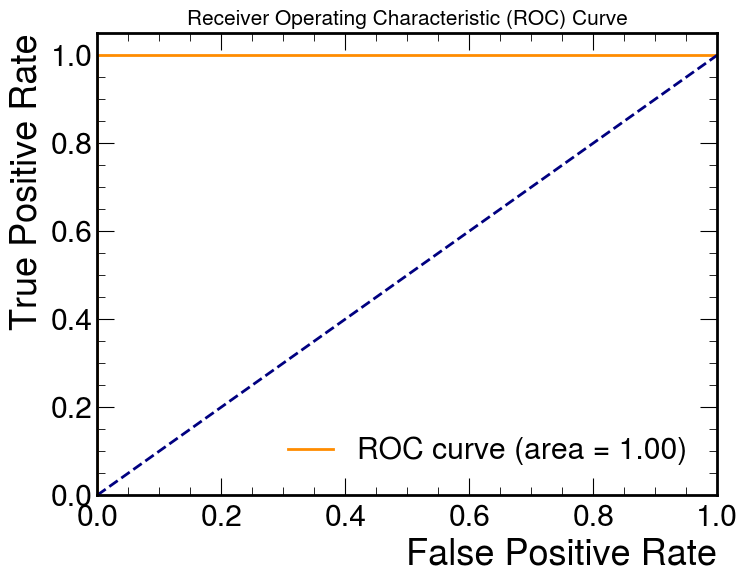

In [ ]:
plot_roc_curve(labels_test, y_pred_teacher)

### 9. Final Model
I'm about to train a cicada_v2 model without any KD, exploiting only QAT for its quantization. <br>
We can modify the architecture to have as output layer a sigmoid activation function since we no longer need to predict the loss of the teacher. But such as before, we give in input the entire training and validation set

Yes there's no need to rewrite the entire class again, I could have accessed the output layer directly. But as I mentioned I was rushing and had troubles to run the code

In [ ]:
class CicadaV2:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        x = QConv2D(
            4,
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            use_bias=False,
            name="dense2",
        )(x)
        outputs = Activation("sigmoid", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")


In [ ]:
only_cicada_dataset = gen.get_generator(images_train, quantize(labels_train), 128, )
only_cicada_val = gen.get_generator(images_val, quantize(labels_val), 128, )

In [ ]:
for epoch in range(5):
    train_model(
        cicada_v2,
        only_cicada_dataset,
        only_cicada_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )

5/5 [==============================] - 0s 3ms/step - loss: 0.1520 - val_loss: 0.0974
Epoch 2/2
5/5 [==============================] - 0s 2ms/step - loss: 0.1142 - val_loss: 0.0617
Epoch 3/3
5/5 [==============================] - 0s 2ms/step - loss: 0.0861 - val_loss: 0.0411
Epoch 4/4
5/5 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0316
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0238


In [ ]:
y_loss_cicada = cicada_v2.predict(np.array(images_test), verbose=1)

7/7 [==============================] - 0s 542us/step


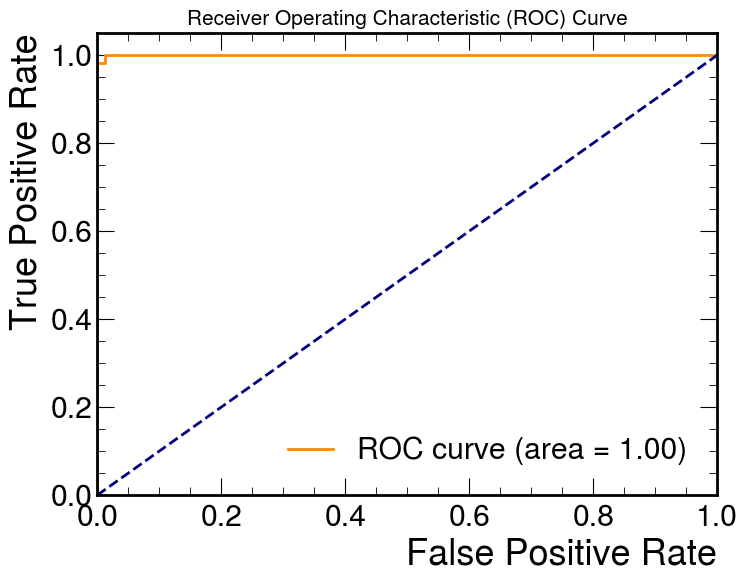

In [ ]:
normalized_output = normalize_matrix(y_loss_cicada)
plot_roc_curve(labels_test, normalized_output)

Since CICADAV2 with minimal training reaches perfect classification, we can go further through a decrease in the number of connections

In [ ]:
cicada_v2.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv (QConv2D)              (None, 8, 8, 4)           16        
                                                                 
 relu0 (QActivation)         (None, 8, 8, 4)           0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                41

In [ ]:
class CicadaV3:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        x = QConv2D(
            2, # decrease the number of filters
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(8, 3, 1, alpha=1.0), # decrease the number of bits (fractional part)
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(8, 3, 1, alpha=1.0), # decrease the number of bits (fractional part)
            use_bias=False,
            name="dense2",
        )(x)
        outputs = Activation("sigmoid", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")

In [ ]:
cicada_v3 = CicadaV3((16, 16)).get_model()
cicada_v3.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

In [ ]:
for epoch in range(10):
    train_model(
        cicada_v3,
        only_cicada_dataset,
        only_cicada_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )

5/5 [==============================] - 0s 22ms/step - loss: 0.3079 - val_loss: 0.2675
Epoch 2/2
5/5 [==============================] - 0s 2ms/step - loss: 0.2718 - val_loss: 0.2447
Epoch 3/3
5/5 [==============================] - 0s 2ms/step - loss: 0.2374 - val_loss: 0.2272
Epoch 4/4
5/5 [==============================] - 0s 2ms/step - loss: 0.2064 - val_loss: 0.2122
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 0.1849 - val_loss: 0.1998
Epoch 6/6
5/5 [==============================] - 0s 2ms/step - loss: 0.1525 - val_loss: 0.1897
Epoch 7/7
5/5 [==============================] - 0s 2ms/step - loss: 0.1429 - val_loss: 0.1799
Epoch 8/8
5/5 [==============================] - 0s 2ms/step - loss: 0.1264 - val_loss: 0.1710
Epoch 9/9
5/5 [==============================] - 0s 2ms/step - loss: 0.1083 - val_loss: 0.1624
Epoch 10/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.1574


7/7 [==============================] - 0s 500us/step


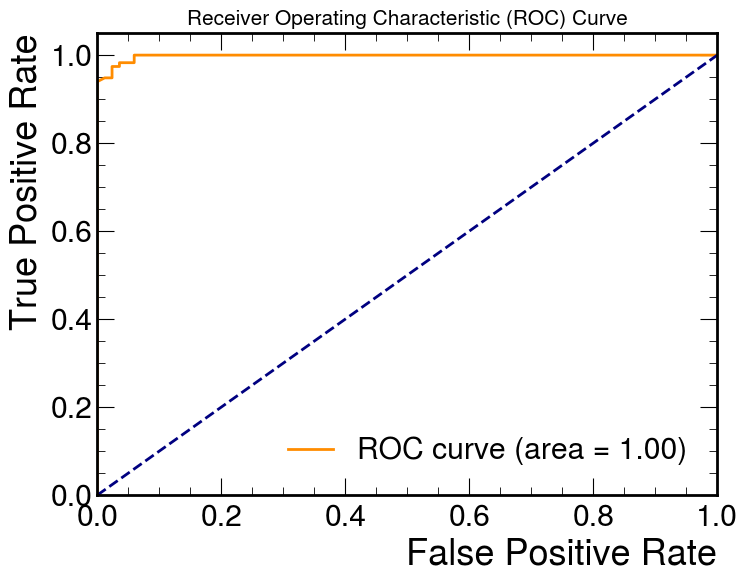

In [ ]:
y_loss_cicada = cicada_v3.predict(np.array(images_test), verbose=1)
plot_roc_curve(labels_test, y_loss_cicada)

In [ ]:
cicada_v3.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv (QConv2D)              (None, 8, 8, 2)           8         
                                                                 
 relu0 (QActivation)         (None, 8, 8, 2)           0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                21

clearly still room for improvement!

In [ ]:
class CicadaV4:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        x = QConv2D(
            1, # decrease the number of filters
            (4, 4),
            strides=4,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(4, 2, 1, alpha=1.0), # decrease the number of bits (fractional part)
            name="conv",
        )(x)
        x = QActivation("quantized_relu(4, 2)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            2,
            kernel_quantizer=quantized_bits(4, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(4, 2, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(4, 2)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(4, 2, 1, alpha=1.0), # decrease the number of bits (fractional part)
            use_bias=False,
            name="dense2",
        )(x)
        outputs = Activation("sigmoid", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")

In [ ]:
cicada_v4 = CicadaV4((16, 16)).get_model()
cicada_v4.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

In [ ]:
for epoch in range(100):
    train_model(
        cicada_v4,
        only_cicada_dataset,
        only_cicada_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )

5/5 [==============================] - 0s 22ms/step - loss: 0.2861 - val_loss: 0.2446
Epoch 2/2
5/5 [==============================] - 0s 1ms/step - loss: 0.2903 - val_loss: 0.2481
Epoch 3/3
5/5 [==============================] - 0s 2ms/step - loss: 0.2918 - val_loss: 0.2481
Epoch 4/4
5/5 [==============================] - 0s 1ms/step - loss: 0.3024 - val_loss: 0.2481
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 0.3001 - val_loss: 0.2481
Epoch 6/6
5/5 [==============================] - 0s 2ms/step - loss: 0.2900 - val_loss: 0.2444
Epoch 7/7
5/5 [==============================] - 0s 1ms/step - loss: 0.2865 - val_loss: 0.2444
Epoch 8/8
5/5 [==============================] - 0s 2ms/step - loss: 0.2795 - val_loss: 0.2444
Epoch 9/9
5/5 [==============================] - 0s 2ms/step - loss: 0.2809 - val_loss: 0.2444
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.2899 - val_loss: 0.2515
Epoch 11/11
5/5 [==============================] - 0s 1ms

7/7 [==============================] - 0s 532us/step
21


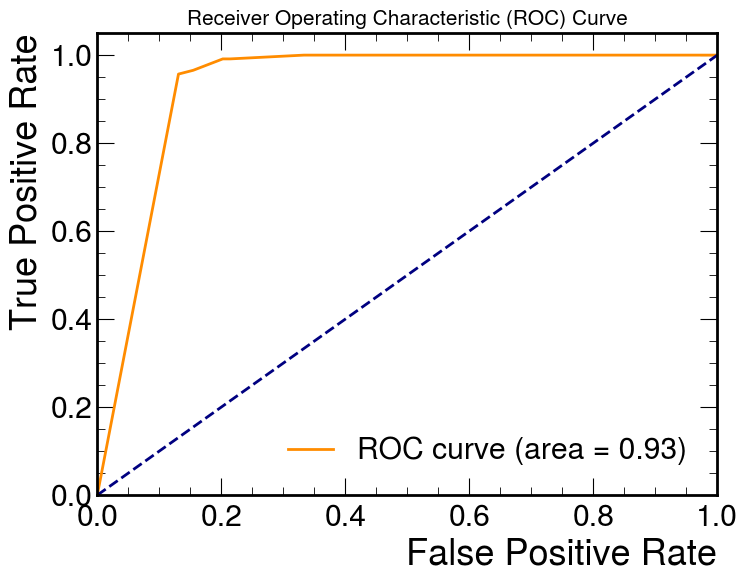

In [ ]:
y_loss_cicada = cicada_v4.predict(np.array(images_test), verbose=1)
plot_roc_curve(labels_test, y_loss_cicada)

In [ ]:
cicada_v4.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv (QConv2D)              (None, 4, 4, 1)           16        
                                                                 
 relu0 (QActivation)         (None, 4, 4, 1)           0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dropout_74 (Dropout)        (None, 16)                0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 2)                 43

We can (almost) count the parameters on the fingers of an hand.

In [ ]:
cicada_v4.evaluate(positive_test_student, verbose=1)

1/1 [==============================] - 0s 114ms/step - loss: 0.2532


0.2531704008579254

In [ ]:
cicada_v4.evaluate(negative_test_student, verbose=1)

1/1 [==============================] - 0s 17ms/step - loss: 0.0929


0.09291359037160873

### 10. HGQ
This is a draft of an attempt with HGQ. After we've seen the performance in the most-extreme mixed-precision training that I came up with, I would have liked to test this new tool. However I wasn't fully able to assess the goodness of this alternative since, for example, I didn't use AutoQKeras to whom HGQ is compared in "*Gradient-based Automatic Mixed Precision Quantization for Neural Networks On-Chip*"


*requirements.txt* doens't contain HGQ due to wrong Python version, I had to switch to 3.10 and had encountered unexpected issues with the environment. 

In [ ]:
from HGQ.layers import HDense, HConv2D, PMaxPooling2D, PFlatten, PReshape, HQuantize, HActivation
from HGQ import ResetMinMax, FreeBOPs
from HGQ import trace_minmax, to_proxy_model

In [ ]:
model = keras.models.Sequential([
    HQuantize(beta=3e-5),
    PReshape((16, 16, 1)),
    PMaxPooling2D((2, 2)),
    HConv2D(1, (3, 3), activation='relu', beta=3e-5, parallel_factor=144),
    PMaxPooling2D((2, 2)),
    HConv2D(1, (3, 3), activation='relu', beta=3e-5, parallel_factor=16),
    #PMaxPooling2D((2, 2)),
    PFlatten(),
    HDense(1, activation='linear', beta=3e-5),
    HActivation('sigmoid')
])

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
loss = 'binary_crossentropy'
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
callbacks = [ResetMinMax(), FreeBOPs()]

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
23/23 [==============================] - 0s 3ms/step - loss: 1.3624 - accuracy: 0.5000 - val_loss: 1.3940 - val_accuracy: 0.5250 - bops: 23340.0000
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 1.3530 - accuracy: 0.5000 - val_loss: 1.3658 - val_accuracy: 0.5250 - bops: 22400.0000
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 1.3115 - accuracy: 0.5000 - val_loss: 1.3088 - val_accuracy: 0.5250 - bops: 20502.0000
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 1.2628 - accuracy: 0.5000 - val_loss: 1.3076 - val_accuracy: 0.5250 - bops: 20461.0000
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 1.2505 - accuracy: 0.5000 - val_loss: 1.2322 - val_accuracy: 0.5250 - bops: 17948.0000
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 1.2018 - accuracy: 0.6056 - val_loss: 1.1734 - val_accuracy: 0.7625 - bops: 19196.0000
Epoch 7/50
23/23 [============================

2025-03-21 22:45:36.563572: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


23/23 [==============================] - 0s 2ms/step - loss: 1.0883 - accuracy: 0.8847 - val_loss: 1.1252 - val_accuracy: 0.8875 - bops: 20481.0000
Epoch 14/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0894 - accuracy: 0.8847 - val_loss: 1.1104 - val_accuracy: 0.8875 - bops: 20585.0000
Epoch 15/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0792 - accuracy: 0.8917 - val_loss: 1.0967 - val_accuracy: 0.8875 - bops: 20489.0000
Epoch 16/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0706 - accuracy: 0.8917 - val_loss: 1.0589 - val_accuracy: 0.9000 - bops: 19637.0000
Epoch 17/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0445 - accuracy: 0.8819 - val_loss: 1.0586 - val_accuracy: 0.9000 - bops: 19626.0000
Epoch 18/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0363 - accuracy: 0.8861 - val_loss: 1.0676 - val_accuracy: 0.8750 - bops: 19590.0000
Epoch 19/50
23/23 [==============================] -

In [ ]:
trace_minmax(model, X_train, cover_factor=1.0)

h_quantize_4: 0.0
h_conv2d_8: 7320.0
h_conv2d_9: 1296.0
h_dense_3: 24.0
h_activation: 0.0


8640.0

### 11. Conclusions and Improvements
I don't wanna repeat myself by thanking once again all the researchers who contributed in those papers. For someone like me, there's hardly a sensation in the academic world as beautiful as feeling totally immersed in the descriptions and the new possibilites presented in what you are reading.
<br>
Yet I can honestly say one thing: I have put my full effort into this project. I dream about opportunities like this one. On an academic level, I don't think you can ask for more than the chance to work with incredible researchers who also seem like wonderful people to be around (I had a fantastic call with Mr. Obama on the CICADA website and a good laugh with Adrian Pol's Github description). Having you as mentors would be amazing, not only as guidance throughout GSoC but also on a personal level, especially at this stage of my life when I am planning to pursue a master's degree abroad.<br>
Apart from meeting the requirements, my goal for this project was to give you a glimpse, a sensation, of the passion I put into it. <br><br>
Enough with the conclusions, let's just list what I would improve:
* check cicada_v4 compute speed and compare it to the provided model
* move utils functions to a separate file (or folder) - this hasn't been done due to delivery time, yet it's super easy
* save model weights
* include plots to compare the different strategies used - not done yet since QAT+KD isn't working
* compile using hls4ml to C++
* optimal quantization with AutoQKeras